# LoFreq variant exploration
We're also going to try the caller LoFreq, which is more specifically intended for the population genetics of haploid species.  [LoFreq](https://csb5.github.io/lofreq/) is a bit older/less recently maintained than some other tools, but is easy and fast to run. It also performs its own internal filtering, so we don't need to filter the outputs the way we do with freebayes.

In [1]:
from os import listdir
from pysam import VariantFile
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gzip
import seaborn as sns

## Read in data

In [5]:
def loadVCF(vcf):
    """
    Use pandas to load a vcf as a dataframe.
    """
    # Detect true header row
    try:
        with gzip.open(vcf, 'rb') as f:
            for i, l in enumerate(f.readlines()):
                if l.decode()[0] != '#':
                    header_row = i - 1 # Want the last row starting with #
                    break
    except gzip.BadGzipFile:
         with open(vcf, 'rb') as f:
            for i, l in enumerate(f.readlines()):
                if l.decode()[0] != '#':
                    header_row = i - 1 # Want the last row starting with #
                    break
                    
    # Load vcf
    df = pd.read_csv(vcf, sep='\t', header=header_row)

    return df

In [6]:
lofreq_output_path = '/mnt/research/Walker_Lab_Research/Serena_project_data/evolved-nanno_data/data/loFreq_output'
variant_dfs = {}
for f in listdir(lofreq_output_path):
    variant_dfs['_'.join(f.split('.')[0].split('_')[:-1])] = loadVCF(f'{lofreq_output_path}/{f}')

A variant is uniquely defined across samples by its position; we'll remove any rows from the two treatment conditions that have the same scaffold and position number as thosei n the control.

In [7]:
for sample, df in variant_dfs.items():
    df['variant_identifier'] = list(zip(df['#CHROM'], df['POS']))

In [8]:
filtered_treatment_samples = {}
for sample in ['0M_R1', '0_1M_R2']:
    df = variant_dfs[sample]
    filtered_df = df[~df['variant_identifier'].isin(variant_dfs['537_control_R2'].variant_identifier)]
    print(f'{len(filtered_df)} of {len(df)} variants ({100*(len(filtered_df)/len(df)):.2f}%) are unique to sample {sample}')
    filtered_treatment_samples[sample] = filtered_df

1392 of 2248 variants (61.92%) are unique to sample 0M_R1
1840 of 2703 variants (68.07%) are unique to sample 0_1M_R2


## Examining filtered outputs
### Transition rates
Now let's plot the transition rates. We'll pair together transitions that are complements of one another, as was done in [Ossowski et al, 2014, Table 2](https://pmc.ncbi.nlm.nih.gov/articles/PMC3878865/table/T2/):
```
A:T→G:C
C:G→T:A
A:T→T:A
C:G→A:T
A:T→C:G
C:G→G:C
```

In [12]:
conversion_pairs = {
    'A:T→G:C': ['A > G', 'T > C'],
    'C:G→T:A': ['C > T', 'G > A'],
    'A:T→T:A': ['A > T', 'T > A'],
    'C:G→A:T': ['C > A', 'G > T'],
    'A:T→C:G': ['A > C', 'T > G'],
    'C:G→G:C': ['C > G', 'G > C']
}
transition_groups = {
    'A > G': 'A:T→G:C',
    'T > C': 'A:T→G:C',
    'C > T': 'C:G→T:A',
    'G > A': 'C:G→T:A',
    'A > T': 'A:T→T:A',
    'T > A': 'A:T→T:A',
    'C > A': 'C:G→A:T',
    'G > T': 'C:G→A:T',
    'A > C': 'A:T→C:G',
    'T > G': 'A:T→C:G',
    'C > G': 'C:G→G:C',
    'G > C': 'C:G→G:C'
}

In [27]:
conversions_to_plot = defaultdict(list)
for sample, df in filtered_treatment_samples.items():
    df.loc[:, 'transition'] = df['REF'] + ' > ' + df['ALT']
    df.loc[:, 'transition_group'] = [transition_groups[t] for t in df['transition']]
    trans_counts = df.groupby('transition_group').count()/len(df)
    sorted_groups = trans_counts.reindex(conversion_pairs.keys())
    for trans, rate in sorted_groups['transition'].items():
        conversions_to_plot[trans].append(rate)

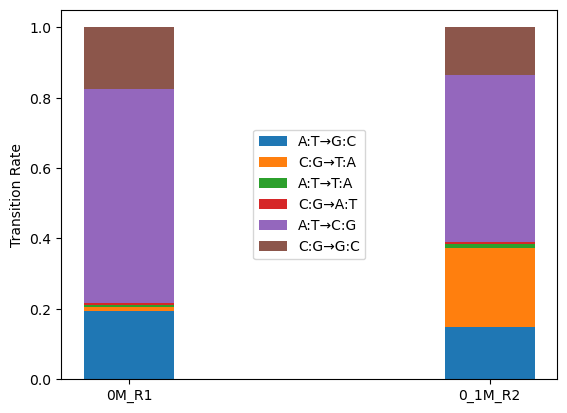

In [25]:
fig, ax = plt.subplots()

width = 0.25
bottom = np.zeros(2)

for name, probs in conversions_to_plot.items():
    ax.bar(filtered_treatment_samples.keys(), probs, width, bottom=bottom, label=f'{name}')
    bottom += probs

ax.set_ylabel('Transition Rate')
ax.legend(loc='center')

plt.show()

What does the unfiltered data look like?

In [28]:
unfiltered_conversions_to_plot = defaultdict(list)
for sample, df in variant_dfs.items():
    df.loc[:, 'transition'] = df['REF'] + ' > ' + df['ALT']
    df.loc[:, 'transition_group'] = [transition_groups[t] for t in df['transition']]
    trans_counts = df.groupby('transition_group').count()/len(df)
    sorted_groups = trans_counts.reindex(conversion_pairs.keys())
    for trans, rate in sorted_groups['transition'].items():
        unfiltered_conversions_to_plot[trans].append(rate)

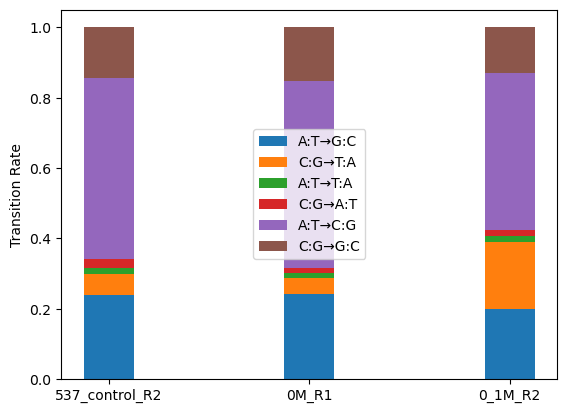

In [30]:
fig, ax = plt.subplots()

width = 0.25
bottom = np.zeros(3)

for name, probs in unfiltered_conversions_to_plot.items():
    ax.bar(variant_dfs.keys(), probs, width, bottom=bottom, label=f'{name}')
    bottom += probs

ax.set_ylabel('Transition Rate')
ax.legend(loc='center')

plt.show()

### Alternate allele frequencies
What do the alternate allele frequencies look like here? Thankfully, LoFreq does this calculation for us.

In [38]:
alt_freqs = defaultdict(list)
for sample, df in filtered_treatment_samples.items():
    alts = df.INFO.str.split(';').str[1].str.split('=').str[1]
    alt_freqs[sample] = alts

In [42]:
for_violin = [(k, float(freq)) for k, v in alt_freqs.items() for freq in v]


for_violin_df = pd.DataFrame.from_records(for_violin, columns=['sample', 'alt_frequency'])
for_violin_df.head()

,sample,alt_frequency
0,0M_R1,0.375000
1,0M_R1,0.432432
2,0M_R1,0.232143
3,0M_R1,0.288889
4,0M_R1,0.311111


<Axes: xlabel='sample', ylabel='alt_frequency'>

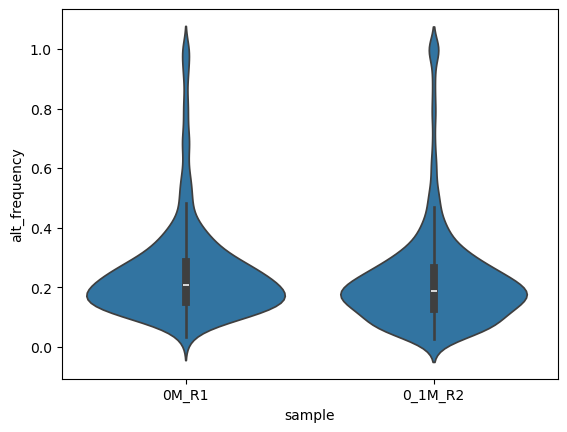

In [43]:
sns.violinplot(for_violin_df, x='sample', y='alt_frequency')

In [45]:
print(f'The maximum frequency alt in 0M_R1 was {max(alt_freqs["0M_R1"])}')
print(f'The maximum frequency alt in 0_1M_R2 was {max(alt_freqs["0_1M_R2"])}')

The maximum frequency alt in 0M_R1 was 1.000000
The maximum frequency alt in 0_1M_R2 was 1.000000


In [49]:
for sample, df in filtered_treatment_samples.items():
    alts = df.INFO.str.split(';').str[1].str.split('=').str[1].astype(float)
    print(f'{len(df[alts == 1])} of {len(df)} variants has a frequency of 100%')

12 of 1392 variants has a frequency of 100%
31 of 1840 variants has a frequency of 100%
